In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
23,711 cases (7 day average) as of Mon 30 Aug, -740.9 since Sun 29 Aug
765 hospitalised (7 day average) as of Wed 01 Sep, +0.0 since Wed 01 Sep
92 died (7 day average) as of Mon 30 Aug, +0.7 since Sun 29 Aug


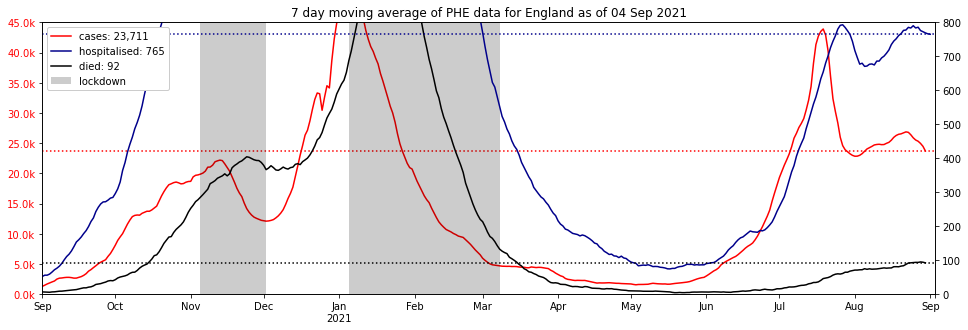

In [3]:
plot_summary(earliest_date='2020-09-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=45_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=800)

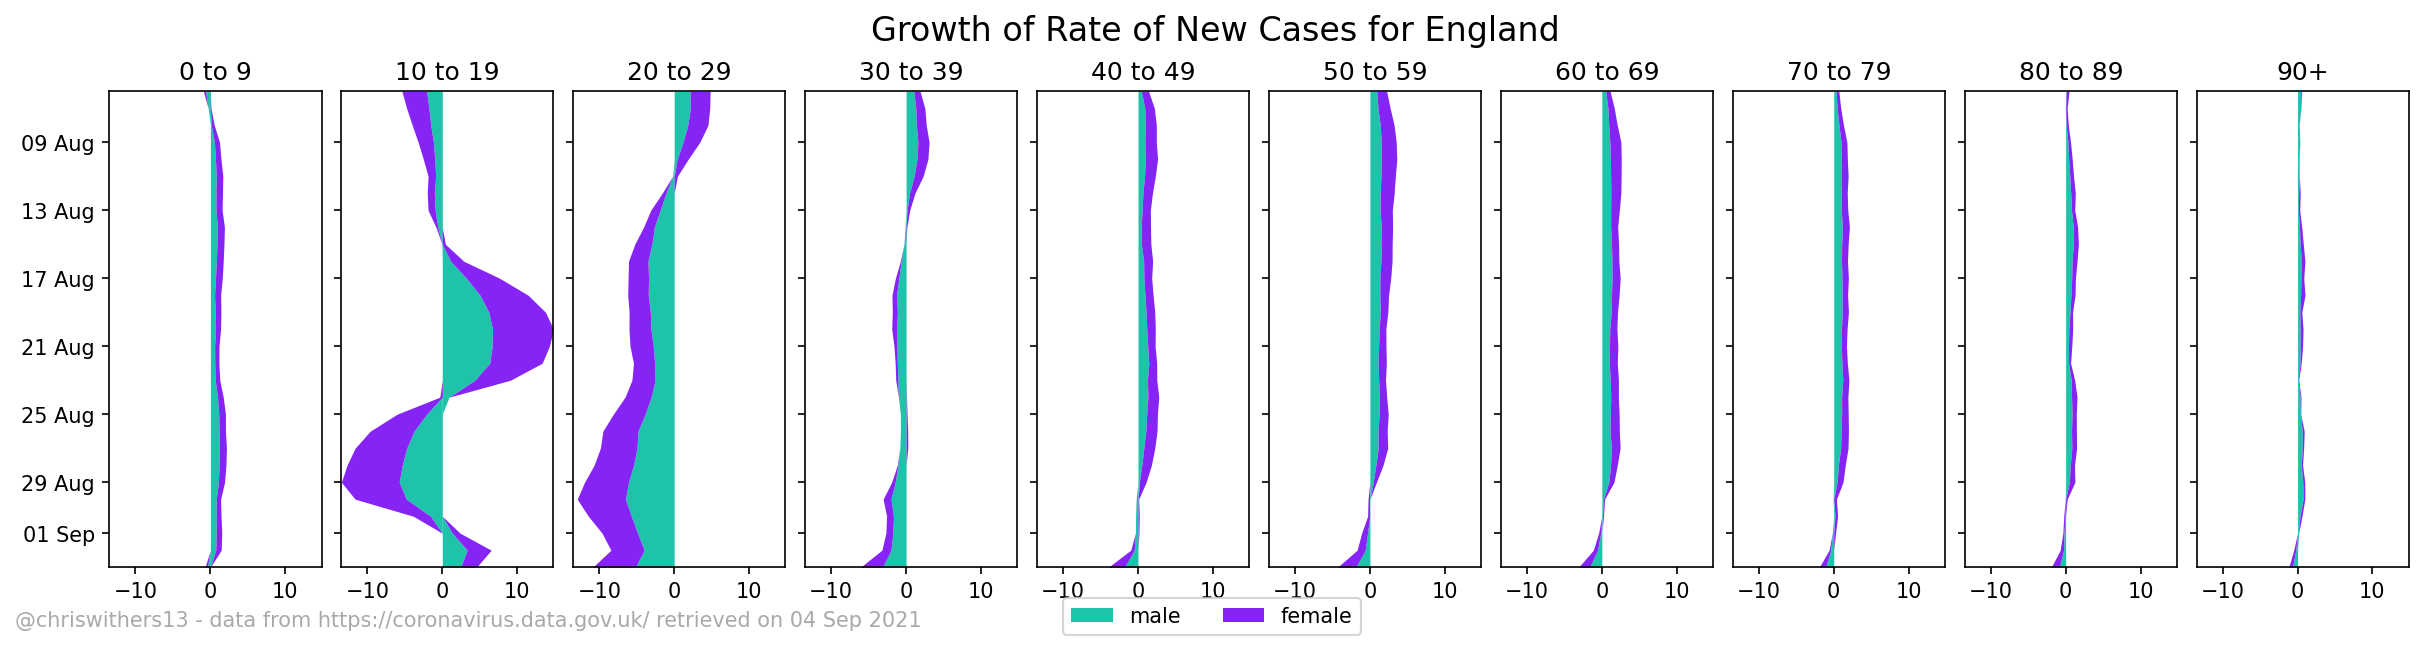

In [4]:
demographic_stream_plot('Growth of Rate of New Cases', order=2, figsize=(16, 4))

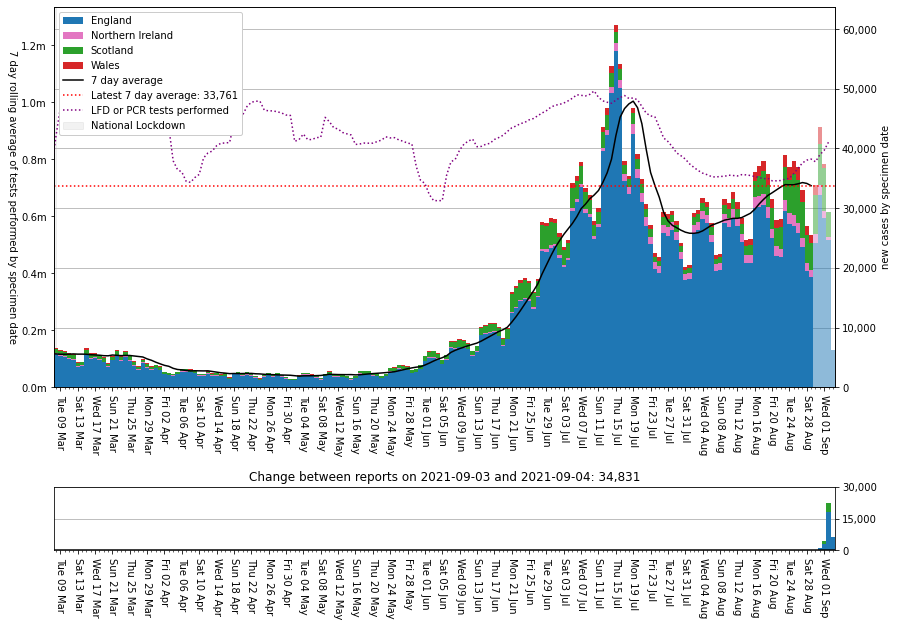

In [5]:
plot_areas(for_date, 'cases_nations', date_format='%a %d %b')

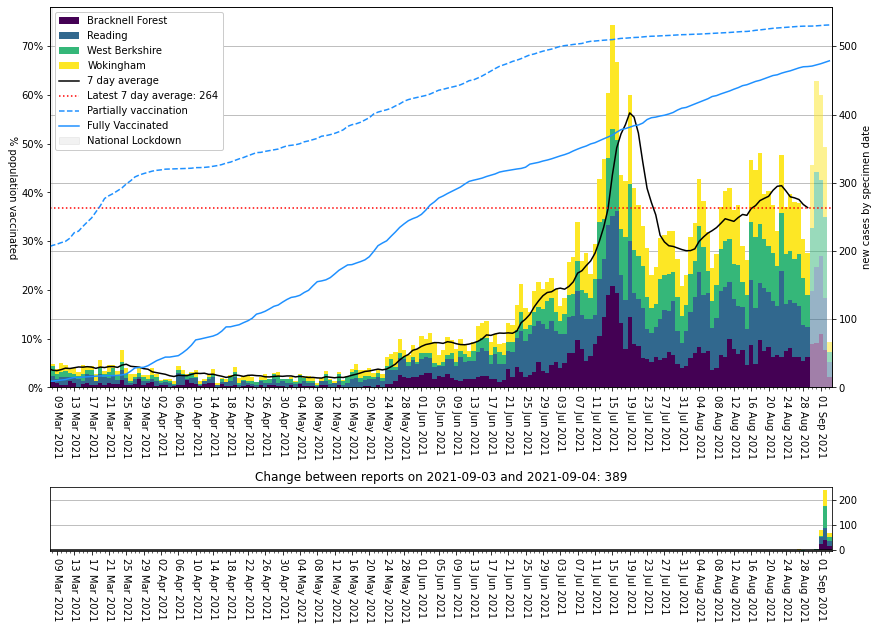

In [6]:
plot_areas(for_date, areas=my_areas, lines=population_vaccinated)

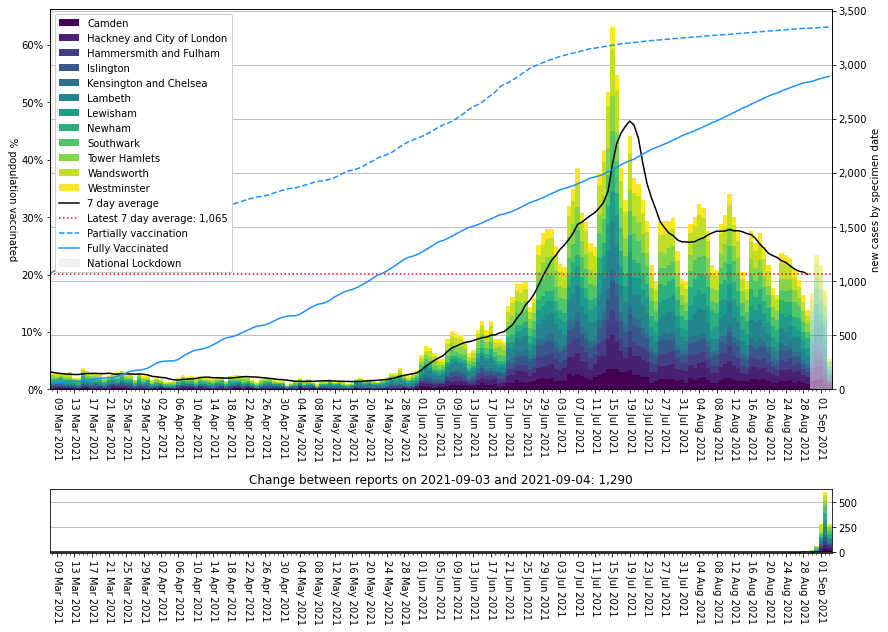

In [7]:
plot_areas(for_date, areas=london_areas, lines=population_vaccinated)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [9]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000050,North Lanarkshire,1012.977122,3458.0,2021-09-03
S12000018,Inverclyde,994.858612,774.0,2021-09-03
S12000011,East Renfrewshire,934.784884,893.0,2021-09-03
S12000038,Renfrewshire,919.597990,1647.0,2021-09-03
S12000039,West Dunbartonshire,901.832902,802.0,2021-09-03
S12000049,Glasgow City,822.908769,5210.0,2021-09-03
S12000045,East Dunbartonshire,822.901325,894.0,2021-09-03
S12000029,South Lanarkshire,794.309425,2546.0,2021-09-03
S12000005,Clackmannanshire,679.084206,350.0,2021-09-03


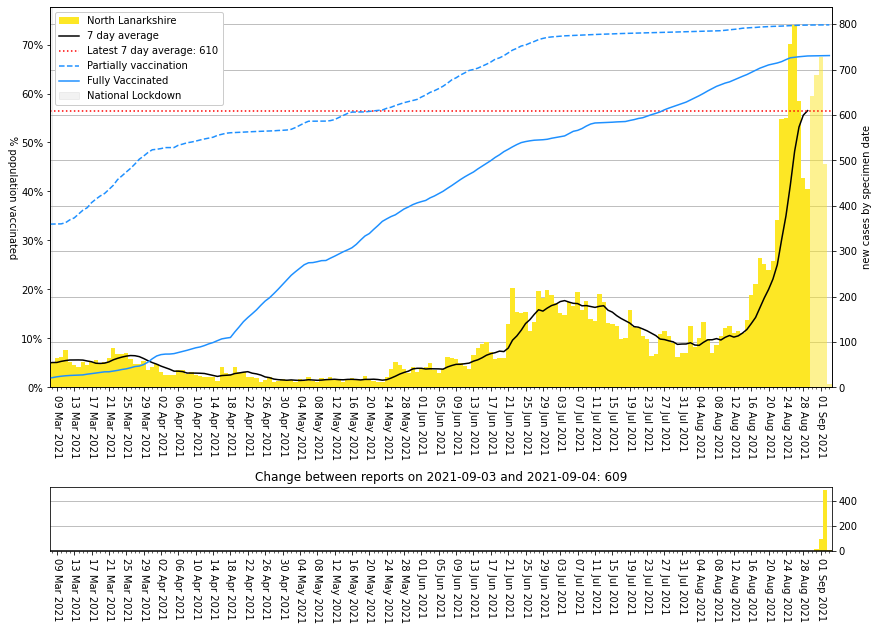

In [10]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=population_vaccinated)

In [11]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000049,Glasgow City,822.908769,5210.0,2021-09-03
S12000050,North Lanarkshire,1012.977122,3458.0,2021-09-03
S12000036,City of Edinburgh,553.978626,2908.0,2021-09-03
E08000025,Birmingham,235.502042,2689.0,2021-09-03
S12000029,South Lanarkshire,794.309425,2546.0,2021-09-03
E08000035,Leeds,286.582806,2273.0,2021-09-03
S12000047,Fife,552.001071,2062.0,2021-09-03
E06000052,Cornwall and Isles of Scilly,343.300653,1963.0,2021-09-03
E08000019,Sheffield,292.210179,1709.0,2021-09-03


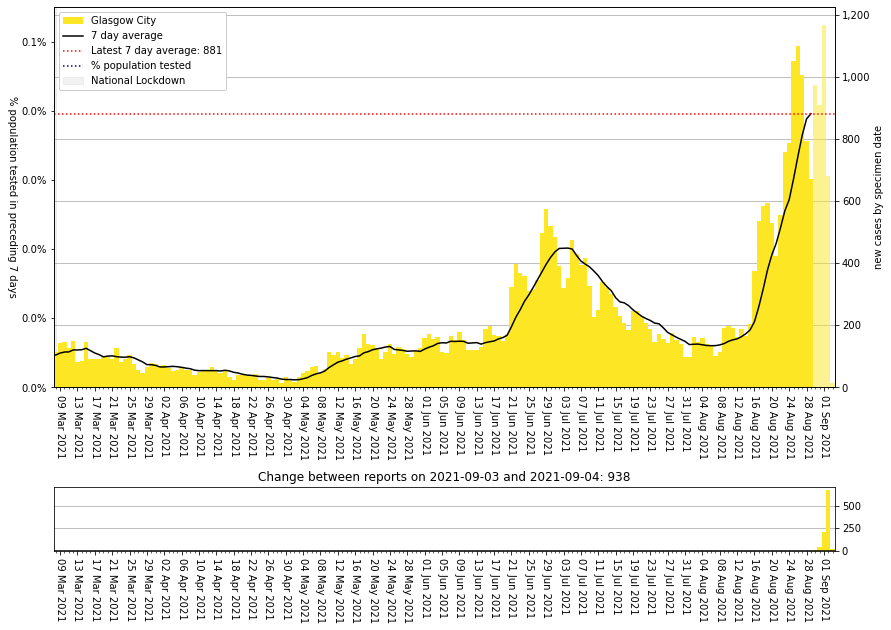

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

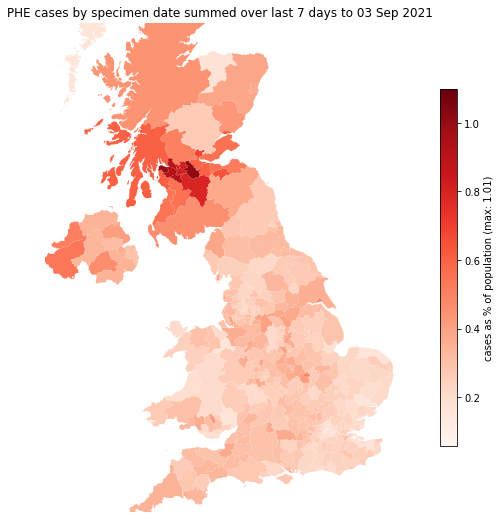

Loading BokehJS ...

In [13]:
summed_maps(for_date, vmax=1.1)

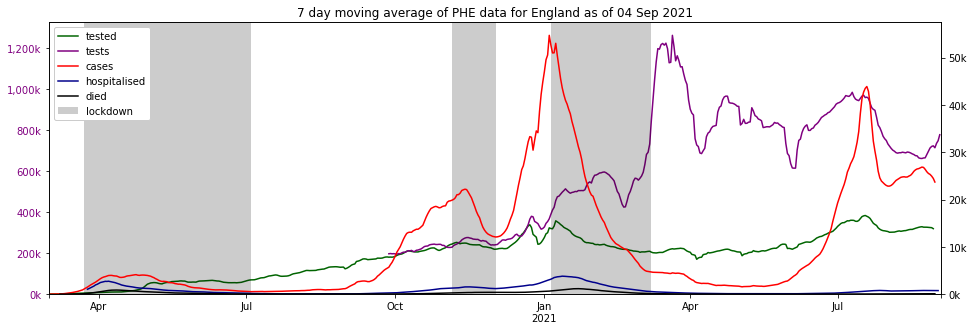

In [14]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

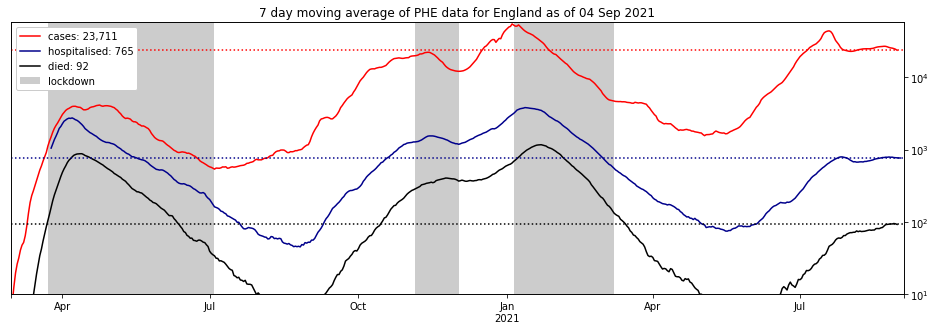

In [15]:
plot_summary(earliest_date='2020-02-29', show_latest='lines', log=True,
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

In [16]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,03 Sep 21,"+36,177,263","+40,440,240","+36,177,263","+98,122","+29,614","+98,122"
Northern Ireland,03 Sep 21,"+1,169,483","+1,290,060","+1,169,483","+1,909","+1,378","+1,909"
Scotland,03 Sep 21,"+3,717,587","+4,117,147","+3,717,587","+8,259","+2,595","+8,259"
Wales,03 Sep 21,"+2,186,704","+2,358,138","+2,186,704",+0,+0,+0


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,36177263.0,40440240.0,4262977.0,56286961,64.272901,7.573649,28.153449
1,Northern Ireland,N92000002,1169483.0,1290060.0,120577.0,1893667,61.757585,6.367381,31.875034
2,Scotland,S92000003,3717587.0,4117147.0,399560.0,5463300,68.046547,7.313528,24.639925
3,Wales,W92000004,2186704.0,2358138.0,171434.0,3152879,69.355786,5.437380,25.206835


'partial: 48,205,585 (72.2%), full: 43,251,037'

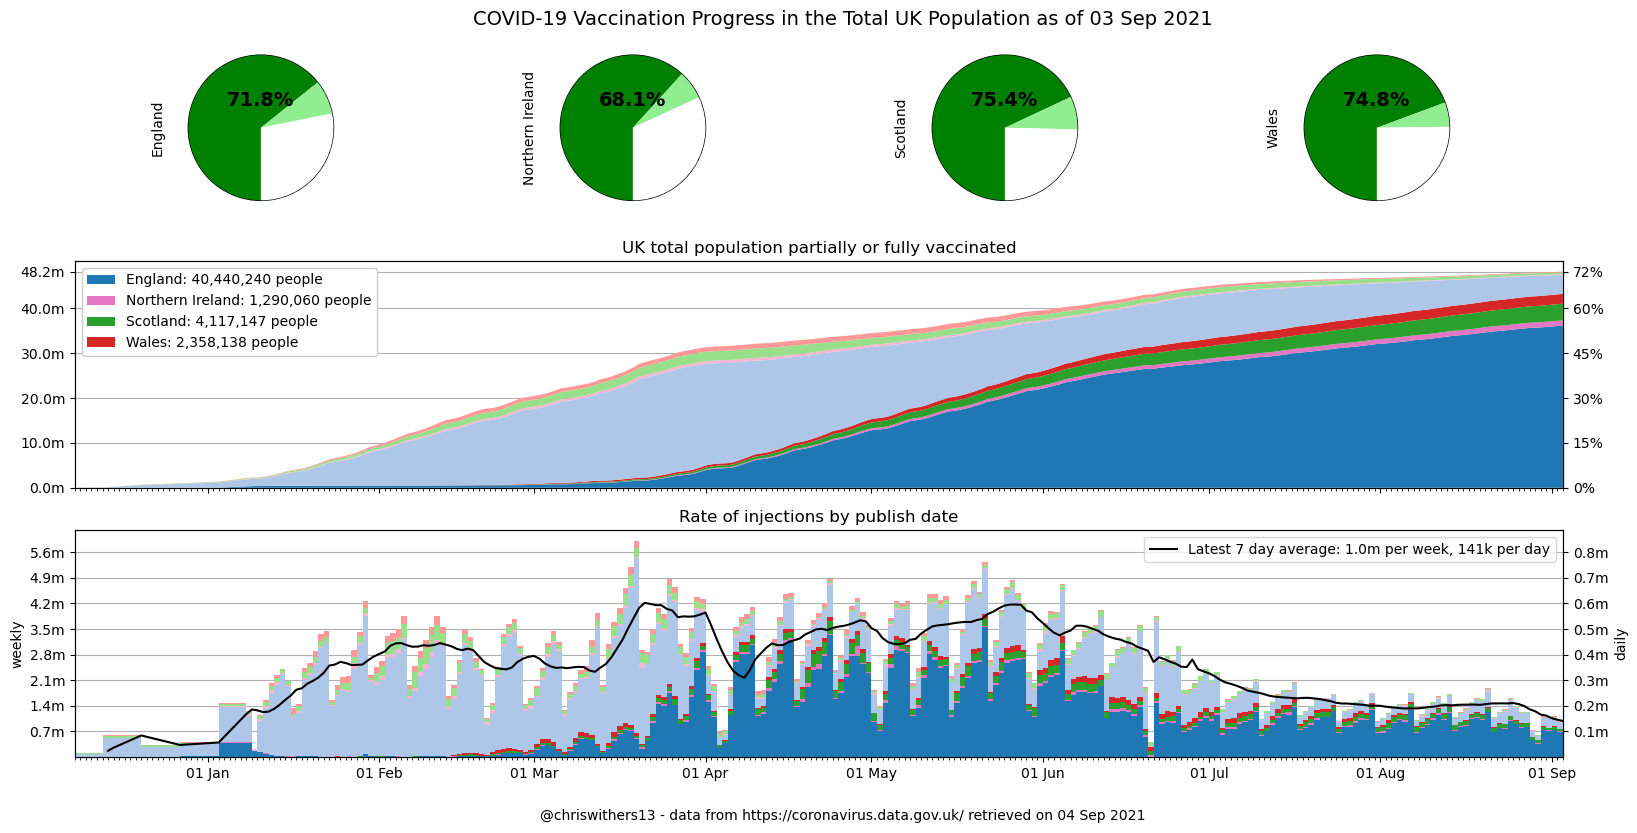

In [17]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")